# <center>HW5</center> #
####
***

## <u>Question 1</u>

### Implementation
* 本次作業要我們使用目前學過的algorithms來分類fashion-mnist dataset。
* 本dataset是一個圖片為主的dataset，training data有60000個sample且維度高達784維，因此方法上將會先嘗試以往Scikit-learn所學的演算法，還會再去藉由tensorflow嘗試Neural network的實作
* 以下將整理本次作業的流程，將會共分三大部分，分別為傳統演算法、DNN(不使用Convolution layer)、CNN。
    * 首先會先使用以往傳統的演算法來解此題，如SVM, KNN, Random forest，並於CPU上進行運算
    * 但由於這幾種建立在Scikit-learn上的演算法並不能倚靠GPU加速，而導致運算量上過於龐大，訓練上若將全部維度丟進去是不太可行的
    * 因此，此部分將會先進行PCA，來取出相對重要的feature，再來進行訓練，並於最後與Neural network的結果來討論
    * 第二，會採用DNN架構來進行分類，也就是使用dense layer(搭配Dropout去處理)，在不使用Convolution layer的情況下進行分類
    * 接著，會使用CNN架構來進行分類，也就是除了dense layer, Dropout layer以外，會使用Conv layer來extract featues，並搭配pooling layer來保持維度和減少參數的使用
    * 最後，CNN的部分會再去嘗試不同的技巧，我的設計中嘗試使用到的是batch-normalization的layer，來幫助我的CNN能夠更快地收斂
    * 除此之外，由於之前有認識到一些有名經典的Convolution Network，因此此處也仿造經典的做法來看看效果如何，我的設計中所嘗試的是VGG style的network
* 資料切分的設定上，由於本身檔案部分已經切分為training set和test set兩份.csv了，因此我的設計上僅需要自己切割出validation set供network使用即可
* 設計上決定讓training set, validation set為0.1的ratio去切，如此一來會分別有54000, 6000筆samples
* 接著則是做一些visualization，畫畫看此dataset的sample來觀察
* 並且除了使用accuracy來計量performance以外，還會搭配confusion matrix來看sample錯誤的情形，並嘗試把一些錯誤的sample給畫出來觀察
<br><br>
* 首先，嘗試傳統ML演算法來進行訓練，但初步就遇到困難，由於資料量、資料維度都過於龐大，若交給CPU去處理需要花費太久的時間，不切實際
* 因此，設計上決定先利用PCA來降維，再丟給CPU去做training，並共嘗試了SVM(RBF kernel), KNN, Randomforest三種演算法，結果的部分會於discussion討論
<br><br>
* DNN的部分，我的設計是先嘗試一層hidden layer，並調整neuron unit個數來到一個合理不會太overfitting的程度
* 嘗試了512~64之間的幾種neuron unit來觀察
* 接著則是看幾種不同的activation function，以及optimizer，然後去決定說較深層的network設計上應該採用何種activation function, optimizer
* 在我的設計中，經過嘗試後，後面是使用 **ReLU + Adam** 的搭配
* 而最後單層hidden layer的DNN最好能夠達到大約 **87%** 的accuracy，已經是不錯的水平
* 訓練中會發現到，單層的hidden layer可調彈性較低，容易造成model overfitting後不好處理，因此嘗試看看加多layer
* 把layer加多以後，再嘗試利用dropout layer來減少overfitting，並且效果是還不錯的
* 但隨著layer加多會發現到，test accuracy已經不是很容易地再向上提升，大約落於 **90%** 左右似乎已是極限，已經比單層hidden layer的DNN表現較優
<br><br>
* 最後一階段，使用CNN來進行training，設計上先使用1conv+1pooling+1FC layer的架構(不包含output的softmax層)進行訓練
* Conv layer的設定大多採用常見的64個filters，3x3 filter size with same padding；Pooling layer則是使用常見的max pooling，以及大小是2x2 size with strides = (2, 2)
* 會發現到overfitting相當嚴重，因此嘗試利用dropout去調整，並搭配epoch的多寡來判斷model收斂程度
* 能夠達到 ** 93%** 的準確度，已經比前面方法都來得優秀了 (甚至能接近94%!)
* 接著，多加幾層conv+pooling進行多方嘗試 (若有需要則適度加入dropout)，表現進步幅度相對小
* 然後，使用看看上課沒有提到的batch-normalization的layer，來幫助我的CNN能夠更快地收斂，或許能間接提升model performance
* 最後，再去訓練的是我自行依照VGG Net的架構去模仿出一個VGG style的network(**花費較多parameters!**)


### Result & Codes

In [2]:
import os
import math
import numpy as np
import pandas as pd
from IPython.display import HTML
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline  
print('Import necessary modules successfully!')

Import necessary modules successfully!


In [3]:
# pd.set_option('display.max_columns', None)
# pd.set_option("max_rows", None)
curr_dir_train = os.getcwd() + r'\fashion-mnist_train.csv'
df_train = pd.read_csv(curr_dir_train)
print('Understand the train data\n')
print(df_train.info())
df_train.head(10)

Understand the train data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None


label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   
5      4       0       0       0       5       4       5       5       3   
6      4       0       0       0       0       0       0       0       0   
7      5       0       0       0       0       0       0       0       0   
8      4       0       0       0       0       0       0       3       2   
9      8       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   
5       5  ...         7         8         7         4         3         7   
6       0  ...        14         0         0         0         0         0   
7       0  ...         0         0         0         0         0         0   
8       0  ...         1         0         0         0         0         0   
9       0  ...       203       214       166         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  
5         5         0         0         0  
6         0         0         0         0  
7         0         0         0         0  
8         0         0         0         0  
9         0         0         0         0  

[10 rows x 785 columns]

In [4]:
curr_dir_test = os.getcwd() + r'\fashion-mnist_test.csv'
df_test = pd.read_csv(curr_dir_test)
print('Understand the test data\n')
print(df_test.info())
df_test.head(10)

Understand the test data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB
None


label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      0       0       0       0       0       0       0       0       9   
1      1       0       0       0       0       0       0       0       0   
2      2       0       0       0       0       0       0      14      53   
3      2       0       0       0       0       0       0       0       0   
4      3       0       0       0       0       0       0       0       0   
5      2       0       0       0       0       0      44     105      44   
6      8       0       0       0       0       0       0       0       0   
7      6       0       0       0       0       0       0       0       1   
8      5       0       0       0       0       0       0       0       0   
9      0       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       8  ...       103        87        56         0         0         0   
1       0  ...        34         0         0         0         0         0   
2      99  ...         0         0         0         0        63        53   
3       0  ...       137       126       140         0       133       224   
4       0  ...         0         0         0         0         0         0   
5      10  ...       105        64        30         0         0         0   
6       0  ...         0         0         0         0         0         0   
7       0  ...       174       136       155        31         0         1   
8       0  ...         0         0         0         0         0         0   
9       0  ...        57        70        28         0         2         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
1         0         0         0         0  
2        31         0         0         0  
3       222        56         0         0  
4         0         0         0         0  
5         0         0         0         0  
6         0         0         0         0  
7         0         0         0         0  
8         0         0         0         0  
9         0         0         0         0  

[10 rows x 785 columns]

In [5]:
print('Check if there is any null values in dataset!\n')
print(f'Train set: {df_train.isnull().values.any()}')
print(f'Test set: {df_test.isnull().values.any()}')

Check if there is any null values in dataset!

Train set: False
Test set: False


In [6]:
from collections import Counter
print('Realize the distribution of labels')
cnt = Counter(df_train['label'])
for i in range(10):
    print(f'label {i}: {cnt[i]}')

Realize the distribution of labels
label 0: 6000
label 1: 6000
label 2: 6000
label 3: 6000
label 4: 6000
label 5: 6000
label 6: 6000
label 7: 6000
label 8: 6000
label 9: 6000


In [7]:
from sklearn.model_selection import train_test_split
class_label = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
X = df_train.iloc[:, 1:].values
y = df_train['label'].values
X_test = df_test.iloc[:, 1:].values
y_test = df_test['label'].values

X_train, X_val ,y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)
print('Data has been split well!')

Data has been split well!


Draw some samples to observe!


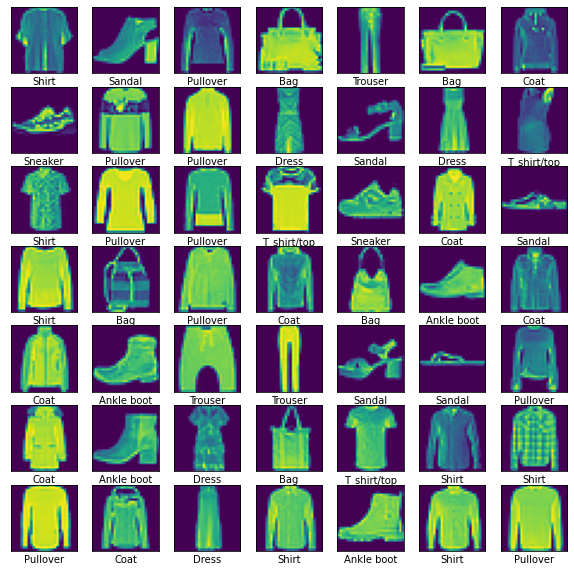

In [8]:
plt.figure(figsize=(10, 10))
for i in range(49):
    plt.subplot(7, 7, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(X_train[i]).reshape(28,28))
    plt.xlabel(class_label[y_train[i]])
print('Draw some samples to observe!')
plt.show()

### <font color="purple">PCA processing for training on some ML algorithms<font>

Train set shape after PCA: (60000, 40)
test set shape after PCA: (10000, 40)


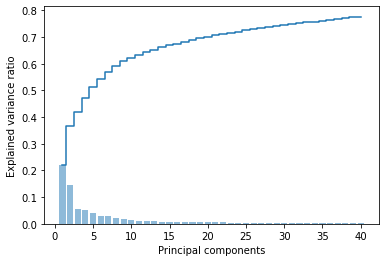

In [9]:
# PCA to lower the computation power
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n_comp = 40

# Standardize
sc = StandardScaler()
sc.fit(X)
X_train_std = sc.transform(X)
X_test_std = sc.transform(X_test)

# Apply PCA
pca = PCA(n_components=n_comp)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

plt.bar(range(1, n_comp + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, n_comp + 1), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
print(f'Train set shape after PCA: {X_train_pca.shape}')
print(f'test set shape after PCA: {X_test_pca.shape}')
plt.show()

### <font color="purple">Set PCA = 40, then the ratio is closed to 0.8. Good enough!<font>

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

print('\nRBF SVM:\n---------------------')

rbf_svm = SVC(kernel = 'rbf', random_state = 1, gamma = 0.01, C = 10)
rbf_svm.fit(X_train_pca, y)
y_pred = rbf_svm.predict(X_test_pca)
target_names = [f"Class {i}" for i in range(10)]
print(classification_report(y_test, y_pred, target_names=target_names))
print(f'Test accuracy: {rbf_svm.score(X_test_pca, y_test)}')


RBF SVM:
---------------------
              precision    recall  f1-score   support

     Class 0       0.82      0.83      0.83      1000
     Class 1       0.99      0.97      0.98      1000
     Class 2       0.82      0.80      0.81      1000
     Class 3       0.91      0.90      0.90      1000
     Class 4       0.82      0.83      0.82      1000
     Class 5       0.96      0.92      0.94      1000
     Class 6       0.72      0.67      0.69      1000
     Class 7       0.92      0.94      0.93      1000
     Class 8       0.87      0.98      0.92      1000
     Class 9       0.94      0.93      0.93      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Test accuracy: 0.8776



RBF SVM:
---------------------
Confusion Matrix: 


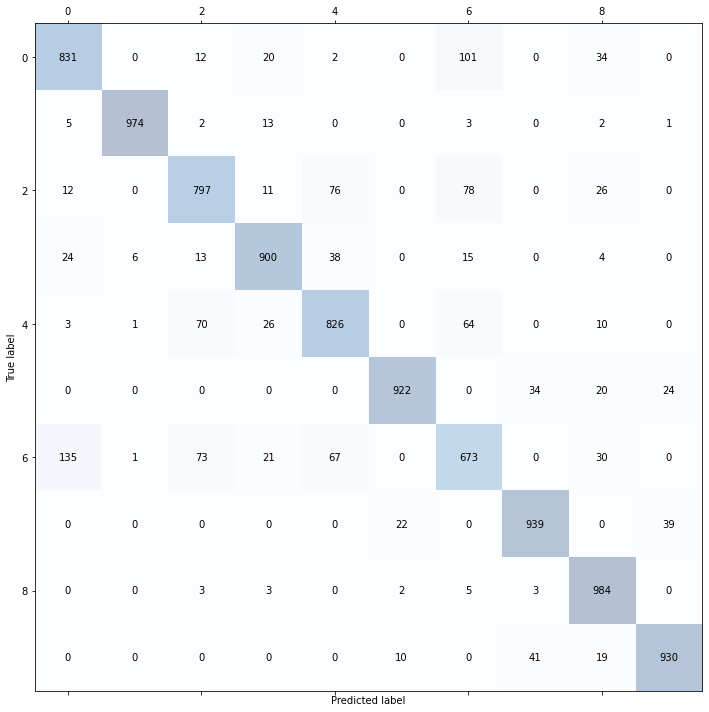

In [11]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
print('\nRBF SVM:\n---------------------\nConfusion Matrix: ')
plt.show()

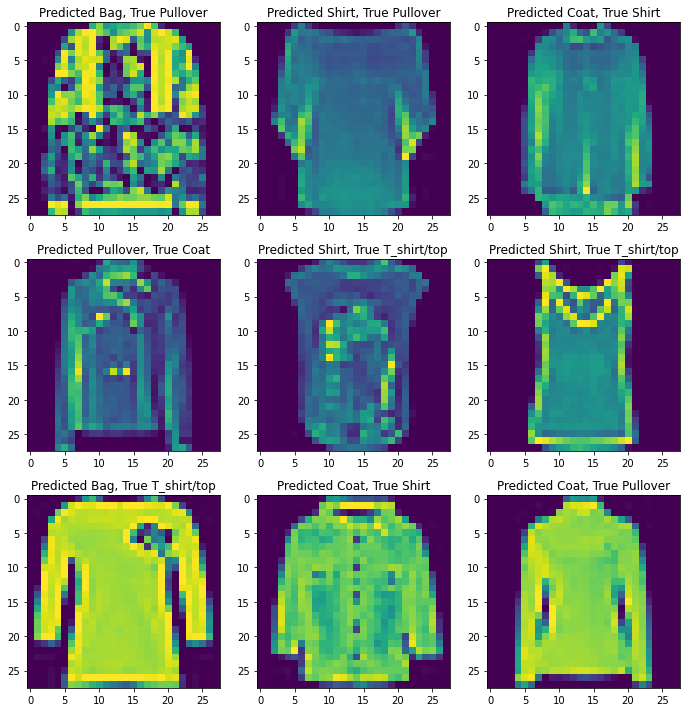

In [12]:
incorrect = np.nonzero(y_pred != y_test)[0]
plt.figure(figsize=(10, 10))
for i, incorrect_idx in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect_idx].reshape(28,28))
    plt.title("Predicted {}, True {}".format(class_label[y_pred[incorrect_idx]], class_label[y_test[incorrect_idx]]))
    plt.tight_layout()

In [13]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=100,
                                max_depth=50,
                                random_state=1,
                                n_jobs=6)
        
forest.fit(X_train_pca, y)
y_pred = forest.predict(X_test_pca)
target_names = [f"Class {i}" for i in range(10)]
print(classification_report(y_test, y_pred, target_names=target_names))
print(f'Test accuracy: {forest.score(X_test_pca, y_test)}')

              precision    recall  f1-score   support

     Class 0       0.79      0.85      0.82      1000
     Class 1       0.99      0.97      0.98      1000
     Class 2       0.80      0.78      0.79      1000
     Class 3       0.87      0.91      0.89      1000
     Class 4       0.78      0.84      0.81      1000
     Class 5       0.93      0.90      0.91      1000
     Class 6       0.72      0.58      0.65      1000
     Class 7       0.89      0.89      0.89      1000
     Class 8       0.94      0.98      0.96      1000
     Class 9       0.90      0.93      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Test accuracy: 0.8633



Random Forest:
---------------------
Confusion Matrix: 


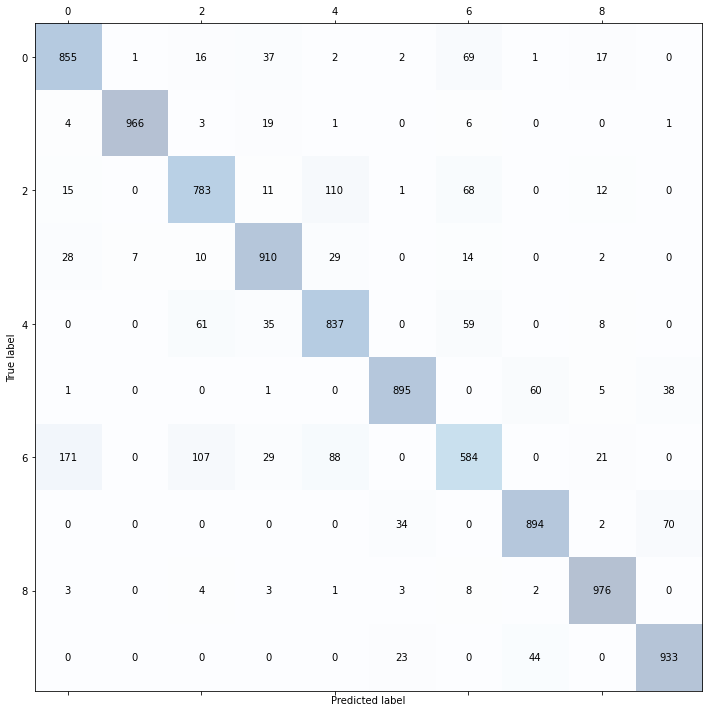

In [14]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
print('\nRandom Forest:\n---------------------\nConfusion Matrix: ')
plt.show()

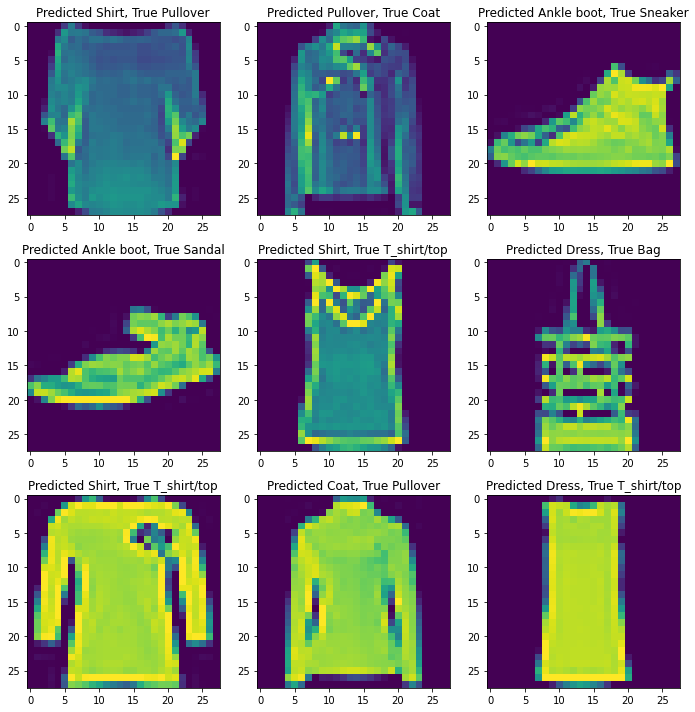

In [15]:
incorrect = np.nonzero(y_pred != y_test)[0]
plt.figure(figsize=(10, 10)) 
for i, incorrect_idx in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect_idx].reshape(28,28))
    plt.title("Predicted {}, True {}".format(class_label[y_pred[incorrect_idx]], class_label[y_test[incorrect_idx]]))
    plt.tight_layout()

In [16]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_pca, y)
y_pred = knn.predict(X_test_pca)
target_names = [f"Class {i}" for i in range(10)]
print(classification_report(y_test, y_pred, target_names=target_names))
print(f'Test accuracy: {knn.score(X_test_pca, y_test)}')

              precision    recall  f1-score   support

     Class 0       0.78      0.84      0.81      1000
     Class 1       0.99      0.97      0.98      1000
     Class 2       0.78      0.77      0.77      1000
     Class 3       0.89      0.90      0.89      1000
     Class 4       0.76      0.80      0.78      1000
     Class 5       0.95      0.88      0.91      1000
     Class 6       0.66      0.60      0.63      1000
     Class 7       0.88      0.91      0.89      1000
     Class 8       0.98      0.95      0.96      1000
     Class 9       0.89      0.94      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.86      0.85     10000

Test accuracy: 0.8553



KNN:
---------------------
Confusion Matrix: 


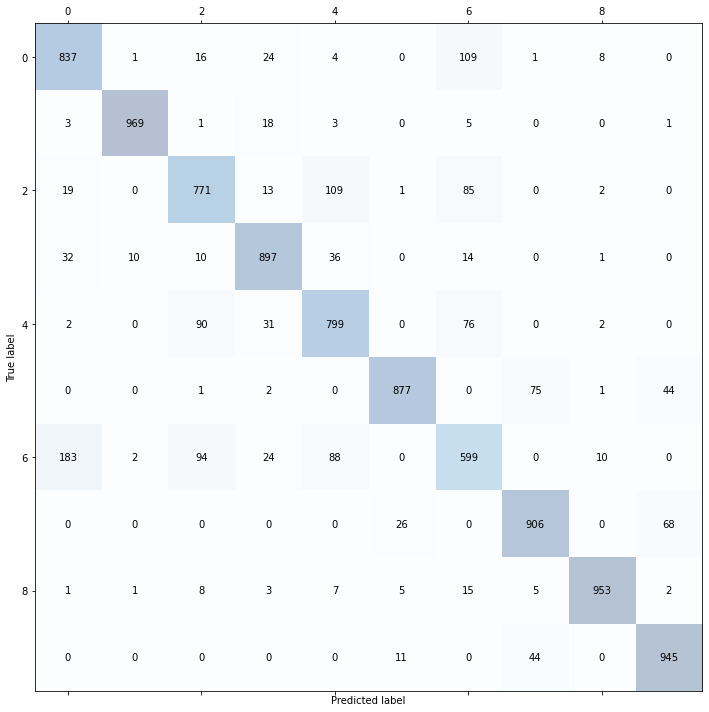

In [17]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
print('\nKNN:\n---------------------\nConfusion Matrix: ')
plt.show()

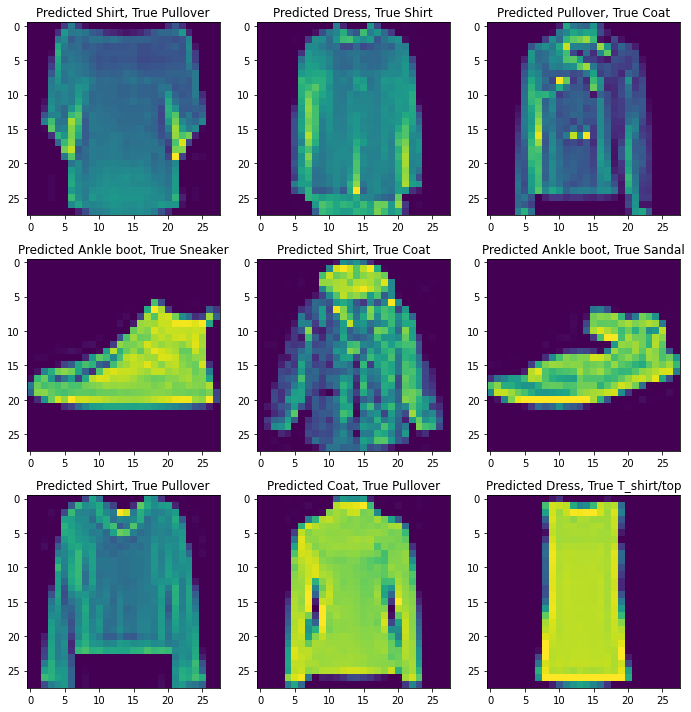

In [18]:
incorrect = np.nonzero(y_pred != y_test)[0]
plt.figure(figsize=(10, 10))
for i, incorrect_idx in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect_idx].reshape(28,28))
    plt.title("Predicted {}, True {}".format(class_label[y_pred[incorrect_idx]], class_label[y_test[incorrect_idx]]))
    plt.tight_layout()

In [19]:
# Scaling them into 0~1 for optimizing the NN easier
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

print('For MLP(DNN) use: ')
print(f'Train set shape: {X_train.shape}, validation set shape: {X_val.shape}, test set shape: {X_test.shape}')
print('------------------')
# Change the input shape
shape_2d = (28, 28, 1)
X_train_2d = X_train.reshape(X_train.shape[0], *shape_2d)
X_test_2d = X_test.reshape(X_test.shape[0], *shape_2d)
X_val_2d = X_val.reshape(X_val.shape[0], *shape_2d)
print('For CNN use: ')
print(f'Train set shape: {X_train_2d.shape}, validation set shape: {X_val_2d.shape}, test set shape: {X_test_2d.shape}')


For MLP(DNN) use: 
Train set shape: (54000, 784), validation set shape: (6000, 784), test set shape: (10000, 784)
------------------
For CNN use: 
Train set shape: (54000, 28, 28, 1), validation set shape: (6000, 28, 28, 1), test set shape: (10000, 28, 28, 1)


### <font color="purple">DNN methods. By default, I select ReLU as my activation, and Adam as my optimizer. 
### <font color="purple">Also, I adjust batch_size = 1024.<font>

In [20]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, SGD

def DNN_one_layer(num_neuron, epochs):
    model = tf.keras.Sequential([
            tf.keras.layers.Dense(num_neuron, activation='relu', input_shape=(784, )),
            tf.keras.layers.Dense(10, activation='softmax'),
    ])
    print(model.summary())
    model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=1024, epochs=epochs, verbose=1, validation_data=(X_val, y_val))
    return model, history
print('Define a one hidden layer function for constructing DNN model!')

Define a one hidden layer function for constructing DNN model!


### <font color="purple">DNN methods. By default, I select ReLU as my activation, and Adam as my optimizer. 

### <font color="purple">Single hidden layer DNN with 512 neurons

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 2s 32us/step - loss: 0.7370 - acc: 0.7486 - val_loss: 0.5232 - val_acc: 0.8195
Epoch 2/20
54000/54000 [==============================] - 1s 10us/step - loss: 0.4649 - acc: 0.8407 - val_loss: 0.4409 - val_acc: 0.8508
Epoch 3/20
54000/54000 [==============================] - 1s 10us/step - loss: 0.4198 - acc: 0.8547 - val_loss: 0.4125 - val_acc: 0.8633
Epoch 4/20
54000/54000 [==============================] - 1s 10us/s

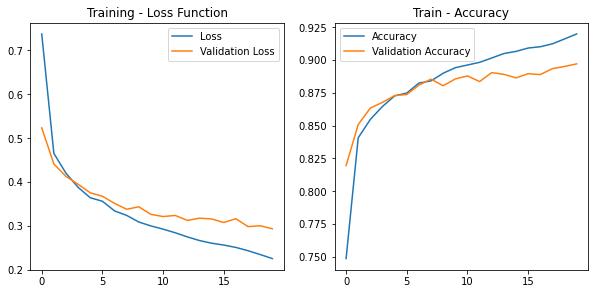

In [21]:
# 1 hidden layer
# DNN with 512 neuron units

dnn_model, dnn_model_history = DNN_one_layer(512, epochs=20)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(dnn_model_history.history['loss'], label='Loss')
plt.plot(dnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(dnn_model_history.history['acc'], label='Accuracy')
plt.plot(dnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

In [22]:
test_loss, test_acc = dnn_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 1s 51us/step
Test Loss: 0.2859863585591316, Test accuracy: 0.8954


### <font color="purple">Overfitting is too obvious! Try 256 neurons!

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 1s 14us/step - loss: 0.8065 - acc: 0.7339 - val_loss: 0.5377 - val_acc: 0.8153
Epoch 2/20
54000/54000 [==============================] - 1s 9us/step - loss: 0.4838 - acc: 0.8349 - val_loss: 0.4647 - val_acc: 0.8390
Epoch 3/20
54000/54000 [==============================] - 1s 10us/step - loss: 0.4388 - acc: 0.8483 - val_loss: 0.4379 - val_acc: 0.8503
Epoch 4/20
54000/54000 [==============================] - 1s 9us/ste

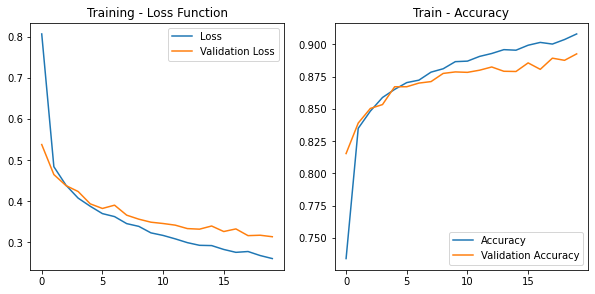

In [23]:
# 1 hidden layer
# DNN with 256 neuron units

dnn_model, dnn_model_history = DNN_one_layer(256, epochs=20)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(dnn_model_history.history['loss'], label='Loss')
plt.plot(dnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(dnn_model_history.history['acc'], label='Accuracy')
plt.plot(dnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

plt.show()


In [24]:
test_loss, test_acc = dnn_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 0s 39us/step
Test Loss: 0.30128838003873826, Test accuracy: 0.892


### <font color="purple">Still overfitting... Try 128 neurons.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 1s 13us/step - loss: 0.8910 - acc: 0.7048 - val_loss: 0.5843 - val_acc: 0.8048
Epoch 2/20
54000/54000 [==============================] - 0s 8us/step - loss: 0.5265 - acc: 0.8196 - val_loss: 0.5000 - val_acc: 0.8342
Epoch 3/20
54000/54000 [==============================] - 0s 8us/step - loss: 0.4726 - acc: 0.8386 - val_loss: 0.4651 - val_acc: 0.8437
Epoch 4/20
54000/54000 [==============================] - 0s 9us/step

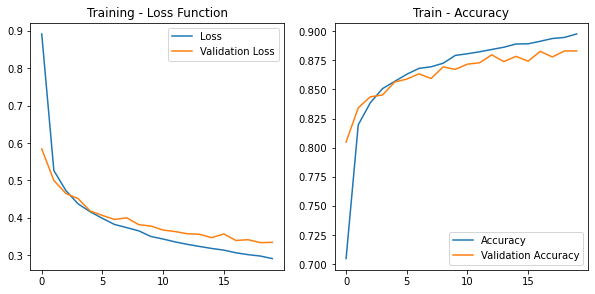

In [25]:
# 1 hidden layer
# DNN

dnn_model, dnn_model_history = DNN_one_layer(128, epochs=20)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(dnn_model_history.history['loss'], label='Loss')
plt.plot(dnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(dnn_model_history.history['acc'], label='Accuracy')
plt.plot(dnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

plt.show()


In [26]:
test_loss, test_acc = dnn_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 0s 45us/step
Test Loss: 0.32892460486888886, Test accuracy: 0.8844


### <font color="purple">Better! And try 64 neurons

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 1s 15us/step - loss: 1.0070 - acc: 0.6688 - val_loss: 0.6582 - val_acc: 0.7715
Epoch 2/20
54000/54000 [==============================] - 0s 9us/step - loss: 0.5734 - acc: 0.8081 - val_loss: 0.5464 - val_acc: 0.8137
Epoch 3/20
54000/54000 [==============================] - 0s 9us/step - loss: 0.5059 - acc: 0.8284 - val_loss: 0.5016 - val_acc: 0.8257
Epoch 4/20
54000/54000 [==============================] - 0s 8us/step -

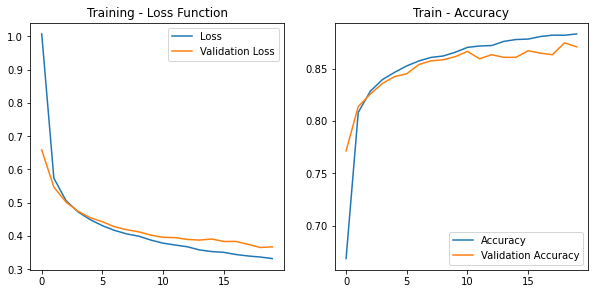

In [27]:
# 1 hidden layer
# DNN
dnn_model, dnn_model_history = DNN_one_layer(64, epochs=20)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(dnn_model_history.history['loss'], label='Loss')
plt.plot(dnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(dnn_model_history.history['acc'], label='Accuracy')
plt.plot(dnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

plt.show()

In [28]:
test_loss, test_acc = dnn_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 0s 43us/step
Test Loss: 0.355930295586586, Test accuracy: 0.8753


### <font color="purple">For one hidden layer MLP, 64 or 128 neurons are less overfitting, so I choose 64 to draw some results.


MLP 64 neurons:
---------------------
Confusion Matrix: 


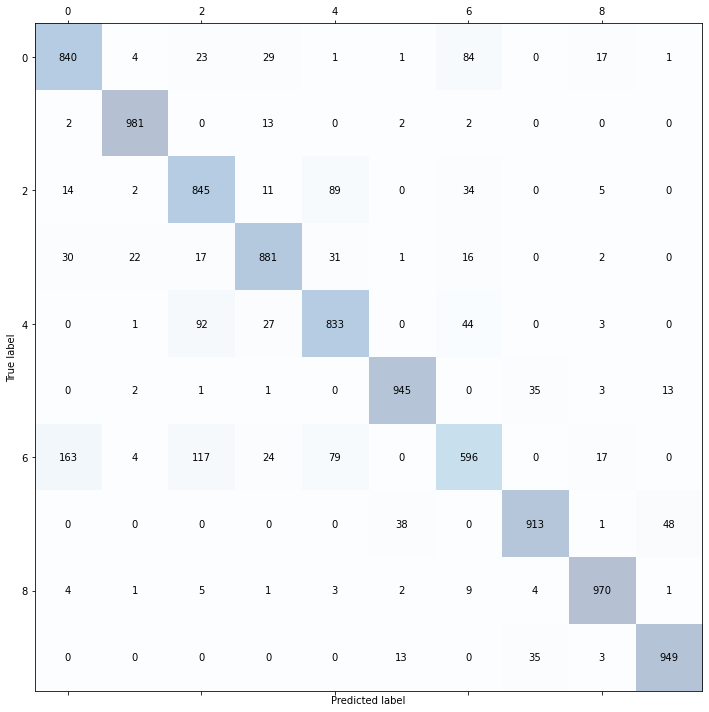

In [29]:
y_pred = dnn_model.predict_classes(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
print('\nMLP 64 neurons:\n---------------------\nConfusion Matrix: ')
plt.show()

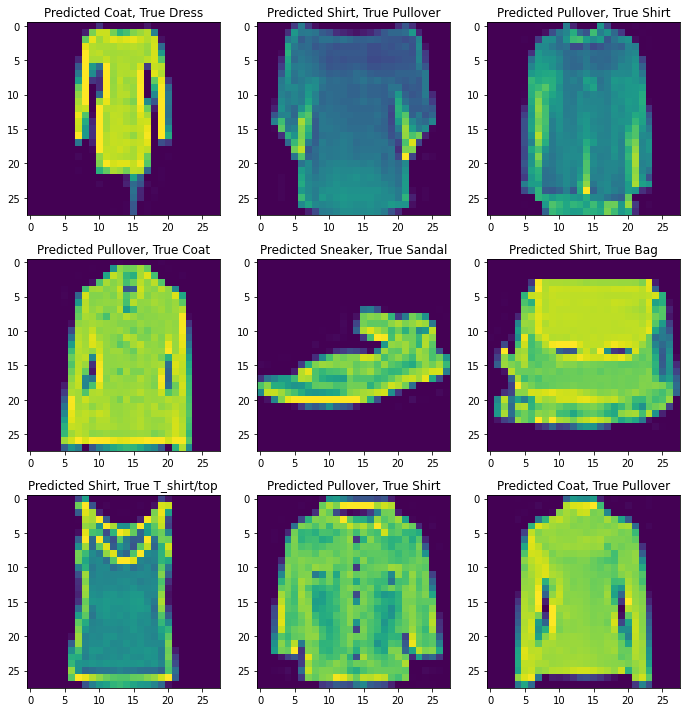

In [30]:
incorrect = np.nonzero(y_pred != y_test)[0]
plt.figure(figsize=(10, 10))
for i, incorrect_idx in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect_idx].reshape(28,28))
    plt.title("Predicted {}, True {}".format(class_label[y_pred[incorrect_idx]], class_label[y_test[incorrect_idx]]))
    plt.tight_layout()

### <font color="purple">Try some different activation functions<font>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 1s 15us/step - loss: 1.5619 - acc: 0.5660 - val_loss: 1.1044 - val_acc: 0.6862
Epoch 2/20
54000/54000 [==============================] - 0s 9us/step - loss: 0.9280 - acc: 0.7429 - val_loss: 0.8264 - val_acc: 0.7565
Epoch 3/20
54000/54000 [==============================] - 0s 9us/step - loss: 0.7386 - acc: 0.7859 - val_loss: 0.6979 - val_acc: 0.7890
Epoch 4/20
54000/54000 [==============================] - 0s 9us/step -

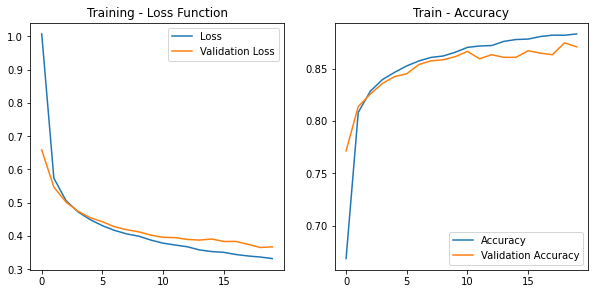

In [31]:
# Use sigmoid as activation function

dnn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='sigmoid', input_shape=(784, )),
        tf.keras.layers.Dense(10, activation='softmax'),
])
print(dnn_model.summary())
dnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = dnn_model.fit(X_train, y_train, batch_size=1024, epochs=20, verbose=1, validation_data=(X_val, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(dnn_model_history.history['loss'], label='Loss')
plt.plot(dnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(dnn_model_history.history['acc'], label='Accuracy')
plt.plot(dnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

plt.show()

In [32]:
test_loss, test_acc = dnn_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 0s 48us/step
Test Loss: 0.3887454650640488, Test accuracy: 0.8652


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 1s 16us/step - loss: 1.0147 - acc: 0.6655 - val_loss: 0.6838 - val_acc: 0.7760
Epoch 2/20
54000/54000 [==============================] - 1s 9us/step - loss: 0.5861 - acc: 0.8086 - val_loss: 0.5505 - val_acc: 0.8150
Epoch 3/20
54000/54000 [==============================] - 0s 9us/step - loss: 0.5036 - acc: 0.8298 - val_loss: 0.4994 - val_acc: 0.8263
Epoch 4/20
54000/54000 [==============================] - 0s 9us/step -

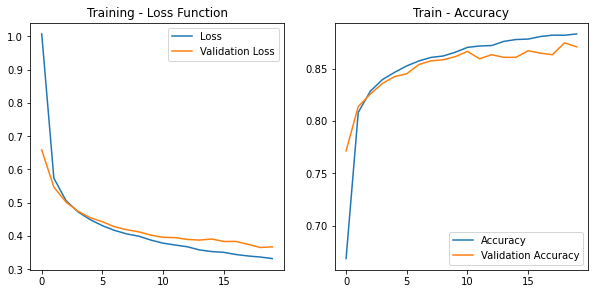

In [33]:
# Use tanh as activation function

dnn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='tanh', input_shape=(784, )),
        tf.keras.layers.Dense(10, activation='softmax'),
])
print(dnn_model.summary())
dnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = dnn_model.fit(X_train, y_train, batch_size=1024, epochs=20, verbose=1, validation_data=(X_val, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(dnn_model_history.history['loss'], label='Loss')
plt.plot(dnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(dnn_model_history.history['acc'], label='Accuracy')
plt.plot(dnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

In [34]:
test_loss, test_acc = dnn_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 0s 42us/step
Test Loss: 0.343081116437912, Test accuracy: 0.8798


### <font color="purple">ReLU is great and easy to compute. So, I select ReLU as my activation function for the rest of training processes!<font>

### <font color="purple">Try different optimizers<font>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 1s 15us/step - loss: 0.9425 - acc: 0.6826 - val_loss: 0.6727 - val_acc: 0.7702
Epoch 2/20
54000/54000 [==============================] - 0s 8us/step - loss: 0.6053 - acc: 0.7921 - val_loss: 0.5698 - val_acc: 0.8010
Epoch 3/20
54000/54000 [==============================] - 0s 8us/step - loss: 0.5300 - acc: 0.8144 - val_loss: 0.5359 - val_acc: 0.8095
Epoch 4/20
54000/54000 [==============================] - 0s 8us/step -

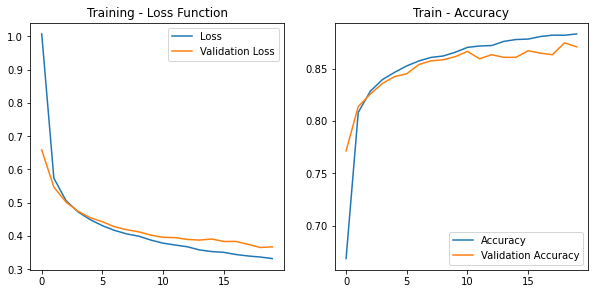

In [35]:
# Use RMSprop

dnn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(784, )),
        tf.keras.layers.Dense(10, activation='softmax'),
])
print(dnn_model.summary())
dnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
history = dnn_model.fit(X_train, y_train, batch_size=1024, epochs=20, verbose=1, validation_data=(X_val, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(dnn_model_history.history['loss'], label='Loss')
plt.plot(dnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(dnn_model_history.history['acc'], label='Accuracy')
plt.plot(dnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

In [36]:
test_loss, test_acc = dnn_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 0s 41us/step
Test Loss: 0.3635211630821228, Test accuracy: 0.868


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 1s 15us/step - loss: 1.0182 - acc: 0.6703 - val_loss: 0.6812 - val_acc: 0.7647
Epoch 2/20
54000/54000 [==============================] - 0s 8us/step - loss: 0.6139 - acc: 0.7912 - val_loss: 0.5803 - val_acc: 0.8065
Epoch 3/20
54000/54000 [==============================] - 0s 8us/step - loss: 0.5483 - acc: 0.8152 - val_loss: 0.5398 - val_acc: 0.8212
Epoch 4/20
54000/54000 [==============================] - 0s 8us/step -

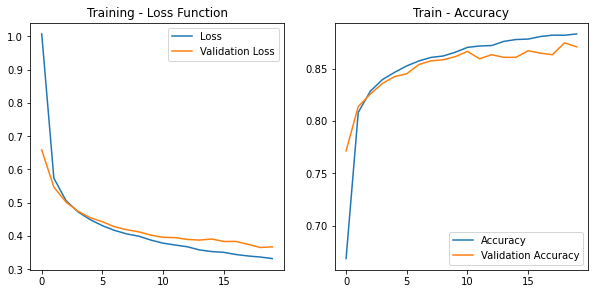

In [37]:
# Use Adagrad

dnn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(784, )),
        tf.keras.layers.Dense(10, activation='softmax'),
])
print(dnn_model.summary())
dnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adagrad(), metrics=['accuracy'])
history = dnn_model.fit(X_train, y_train, batch_size=1024, epochs=20, verbose=1, validation_data=(X_val, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(dnn_model_history.history['loss'], label='Loss')
plt.plot(dnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(dnn_model_history.history['acc'], label='Accuracy')
plt.plot(dnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

In [38]:
test_loss, test_acc = dnn_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 0s 43us/step
Test Loss: 0.3920530001401901, Test accuracy: 0.8643


### <font color="purple">No huge difference, so I decide to select Adam optimizer since it performs a little bit better than others<font>

### <font color="purple">Single hidden layer MLP can have test accuracy which is around 87%, not bad!<font>

### <font color="purple">Single hidden layer MLP is prone to overfitting in the early training process...<font>

### <font color="purple">So, try to use multi-hidden-layer DNN!<font>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_18 (Dense)             (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 1s 20us/step - loss: 0.8039 - acc: 0.7259 - val_loss: 0.5180 - val_acc: 0.8280
Epoch 2/50
54000/54000 [==============================] - 1s 11us/step - loss: 0.4687 - acc: 0.8362 - val_loss: 0.4694 - val_acc: 0.8413
Epoch 3/50
54000/54000 [==============================] - 1s 11us/step -

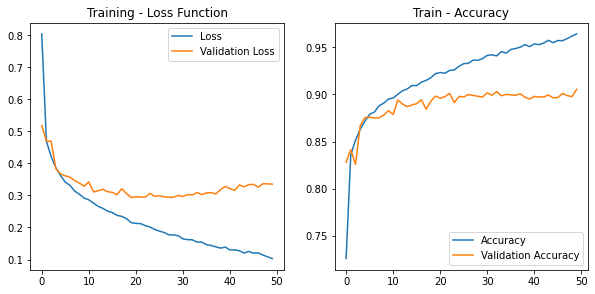

In [39]:
multi_layer_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(784, )),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
])
print(multi_layer_model.summary())
multi_layer_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
multi_layer_model_history = multi_layer_model.fit(X_train, y_train, batch_size=1024, epochs=50, verbose=1, validation_data=(X_val, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(multi_layer_model_history.history['loss'], label='Loss')
plt.plot(multi_layer_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(multi_layer_model_history.history['acc'], label='Accuracy')
plt.plot(multi_layer_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

# y_pred = model.predict_classes(X_test)
test_loss, test_acc = multi_layer_model.evaluate(X_test, y_test)
print(test_loss, test_acc)

plt.show()

In [40]:
test_loss, test_acc = multi_layer_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 0s 46us/step
Test Loss: 0.32289162412285805, Test accuracy: 0.8967


### <font color="purple">Overfitting is serious! Try to add some dropout layer!<font>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_21 (Dense)             (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 1s 20us/step - loss: 0.9113 - acc: 0.6845 - val_loss: 0.5354 - val_acc: 0.8083
Epoch 2/50
54000/54000 [==============================] - 1s 10us/step - loss

Text(0.5, 1.0, 'Train - Accuracy')

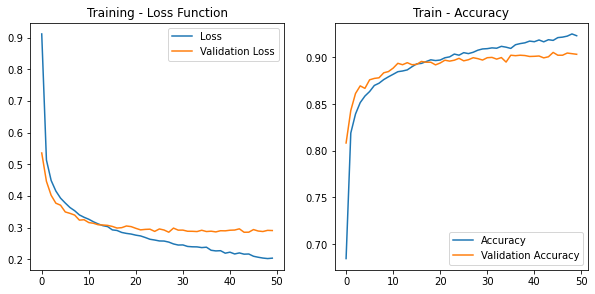

In [41]:
multi_layer_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(784, )),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
])
print(multi_layer_model.summary())
multi_layer_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
multi_layer_model_history = multi_layer_model.fit(X_train, y_train, batch_size=1024, epochs=50, verbose=1, validation_data=(X_val, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(multi_layer_model_history.history['loss'], label='Loss')
plt.plot(multi_layer_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(multi_layer_model_history.history['acc'], label='Accuracy')
plt.plot(multi_layer_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [42]:
test_loss, test_acc = multi_layer_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 0s 46us/step
Test Loss: 0.2980555110245943, Test accuracy: 0.897


### <font color="purple">Not so serious, but still has some overfitting... Try to add more dropout layer<font>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 1s 21us/step - loss: 1.1

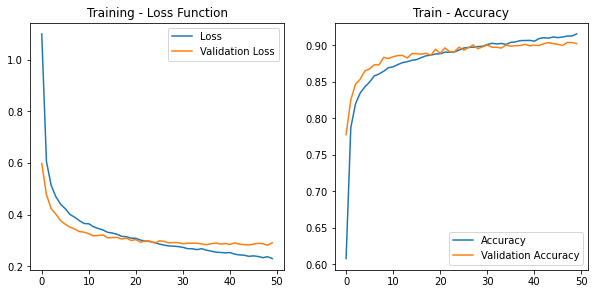

In [43]:
multi_layer_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(784, )),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation='softmax'),
])
print(multi_layer_model.summary())
multi_layer_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
multi_layer_model_history = multi_layer_model.fit(X_train, y_train, batch_size=1024, epochs=50, verbose=1, validation_data=(X_val, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(multi_layer_model_history.history['loss'], label='Loss')
plt.plot(multi_layer_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(multi_layer_model_history.history['acc'], label='Accuracy')
plt.plot(multi_layer_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

plt.show()

In [44]:
test_loss, test_acc = multi_layer_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 1s 51us/step
Test Loss: 0.2930120132088661, Test accuracy: 0.8976


### <font color="purple">Good! (with test accuracy ~90%) Maybe it can be better! Let's make DNN deeper!<font>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_28 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)                1290      
Total para

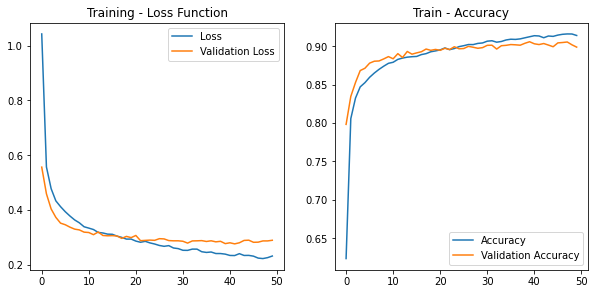

In [45]:
multi_layer_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(784, )),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation='softmax'),
])
print(multi_layer_model.summary())
multi_layer_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
multi_layer_model_history = multi_layer_model.fit(X_train, y_train, batch_size=1024, epochs=50, verbose=1, validation_data=(X_val, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(multi_layer_model_history.history['loss'], label='Loss')
plt.plot(multi_layer_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(multi_layer_model_history.history['acc'], label='Accuracy')
plt.plot(multi_layer_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

In [46]:
test_loss, test_acc = multi_layer_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 0s 50us/step
Test Loss: 0.2949205656886101, Test accuracy: 0.8987


### <font color="purple">A little bit overfitting, so add some dropout layer<font>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
__________

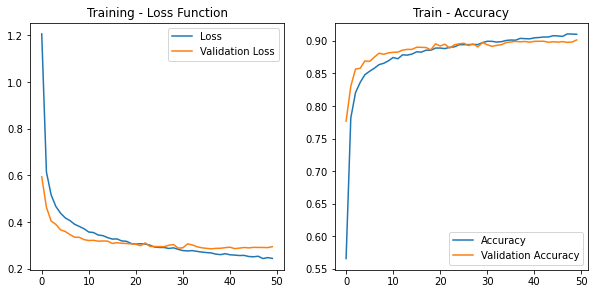

In [47]:
multi_layer_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(784, )),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4), # add more dropout
        tf.keras.layers.Dense(10, activation='softmax'),
])
print(multi_layer_model.summary())
multi_layer_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
multi_layer_model_history = multi_layer_model.fit(X_train, y_train, batch_size=1024, epochs=50, verbose=1, validation_data=(X_val, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(multi_layer_model_history.history['loss'], label='Loss')
plt.plot(multi_layer_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(multi_layer_model_history.history['acc'], label='Accuracy')
plt.plot(multi_layer_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

plt.show()

In [48]:
test_loss, test_acc = multi_layer_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 1s 58us/step
Test Loss: 0.2970050678402185, Test accuracy: 0.8982


### <font color="purple">Almost no overfitting! Try to add more one dropout layer<font>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)               16512     
__________

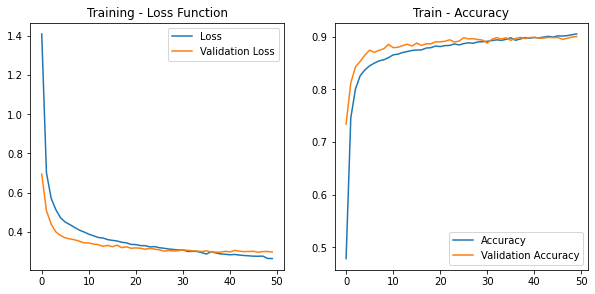

In [49]:
multi_layer_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(784, )),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation='softmax'),
])
print(multi_layer_model.summary())
multi_layer_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
multi_layer_model_history = multi_layer_model.fit(X_train, y_train, batch_size=1024, epochs=50, verbose=1, validation_data=(X_val, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(multi_layer_model_history.history['loss'], label='Loss')
plt.plot(multi_layer_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(multi_layer_model_history.history['acc'], label='Accuracy')
plt.plot(multi_layer_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

plt.show()

In [50]:
test_loss, test_acc = multi_layer_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 1s 57us/step
Test Loss: 0.29789296533465387, Test accuracy: 0.8965


### <font color="purple">Overfitting is almost disappeared! So, draw some results to observe. <font>

### <font color="purple">But, test accuracy is not improved much.. <font>


MLP:
---------------------
Confusion Matrix: 


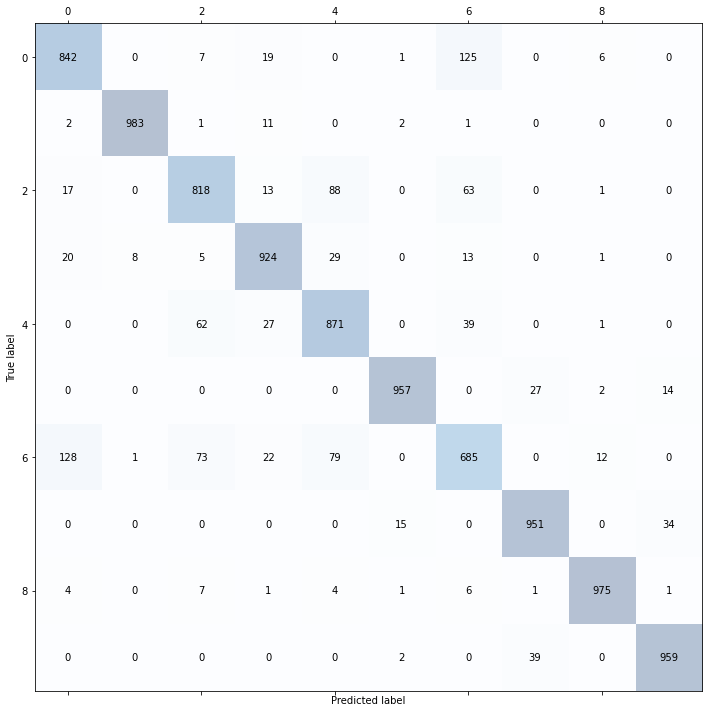

In [51]:
y_pred = multi_layer_model.predict_classes(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
print('\nMLP:\n---------------------\nConfusion Matrix: ')
plt.show()

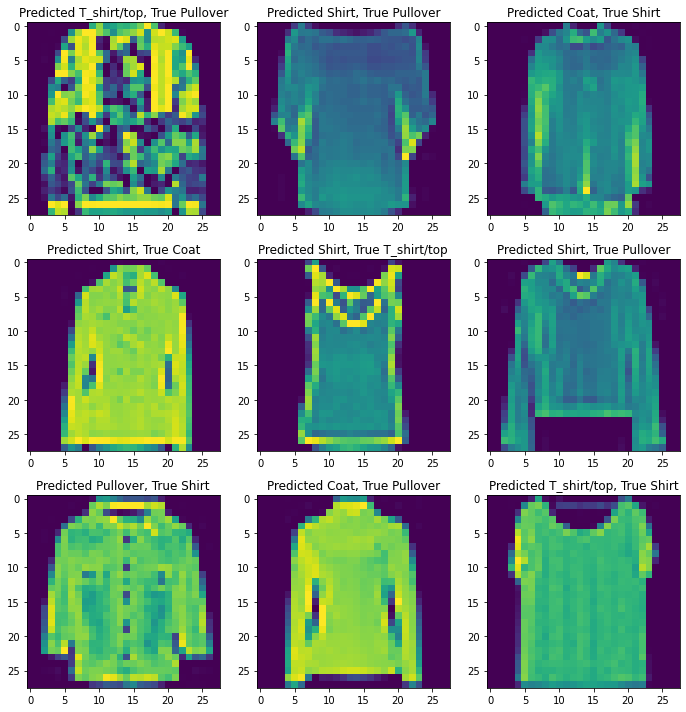

In [52]:
incorrect = np.nonzero(y_pred != y_test)[0]
plt.figure(figsize=(10, 10))
for i, incorrect_idx in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect_idx].reshape(28,28))
    plt.title("Predicted {}, True {}".format(class_label[y_pred[incorrect_idx]], class_label[y_test[incorrect_idx]]))
    plt.tight_layout()

### <font color="purple">So, I think DNN methods can be around 90%(test acc) and it's better than other ML algorithms I've tried though!<font>

### <font color="purple">Try some CNN model!<font>

### <font color="purple">First, try 1 conv layer+ 1 pooling layer + 1 FC layer<font>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        640       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_60 (Dense)             (None, 64)                802880    
_________________________________________________________________
dense_61 (Dense)             (None, 10)                650       
Total params: 804,170
Trainable params: 804,170
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 3s 65us/step - loss: 0.7

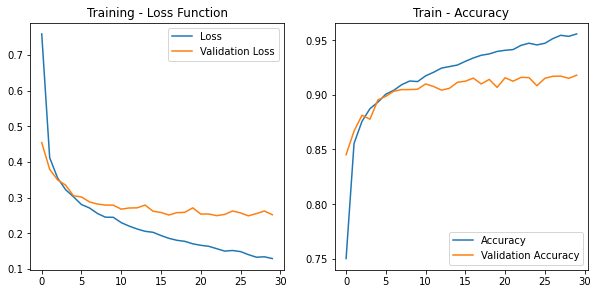

In [72]:
# 1 conv layer + 1 pooling layer

cnn_model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
])
print(cnn_model.summary())
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
cnn_model_history = cnn_model.fit(X_train_2d, y_train, batch_size=1024, epochs=30, verbose=1, validation_data=(X_val_2d, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(cnn_model_history.history['loss'], label='Loss')
plt.plot(cnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(cnn_model_history.history['acc'], label='Accuracy')
plt.plot(cnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

In [73]:
test_loss, test_acc = cnn_model.evaluate(X_test_2d, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 1s 80us/step
Test Loss: 0.23309863178730011, Test accuracy: 0.9195


### <font color="purple">Overfitting is too much! Need to address it by dropout layer.<font>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        640       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_62 (Dense)             (None, 64)                802880    
_________________________________________________________________
dense_63 (Dense)             (None, 10)                650       
Total params: 804,170
Trainable params: 804,170
Non-trainable params: 0
_________________________________________________________________
None

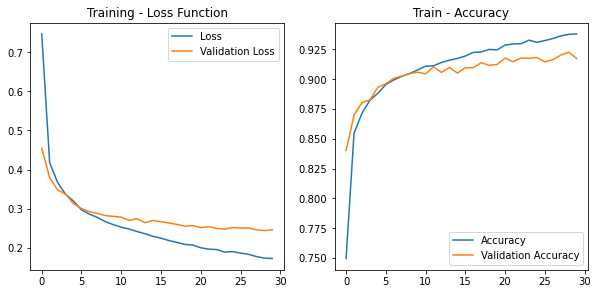

In [74]:
cnn_model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
])
print(cnn_model.summary())
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
cnn_model_history = cnn_model.fit(X_train_2d, y_train, batch_size=1024, epochs=30, verbose=1, validation_data=(X_val_2d, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(cnn_model_history.history['loss'], label='Loss')
plt.plot(cnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(cnn_model_history.history['acc'], label='Accuracy')
plt.plot(cnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

# y_pred = model.predict_classes(X_test)


plt.show()

In [75]:
test_loss, test_acc = cnn_model.evaluate(X_test_2d, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 1s 80us/step
Test Loss: 0.22506211493611336, Test accuracy: 0.92


### <font color="purple">Still has some overfitting, add more dropout layer!<font>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        640       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_64 (Dense)             (None, 64)                802880    
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 10)                650       
Total para

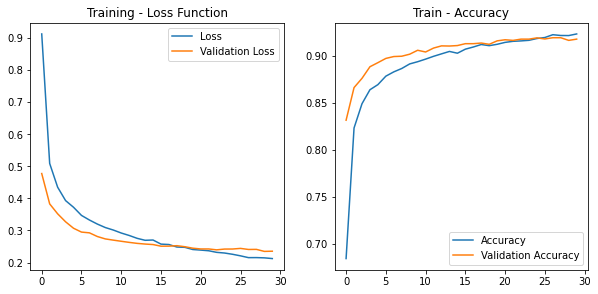

In [76]:
cnn_model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(10, activation='softmax')
])
print(cnn_model.summary())
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
cnn_model_history = cnn_model.fit(X_train_2d, y_train, batch_size=1024, epochs=30, verbose=1, validation_data=(X_val_2d, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(cnn_model_history.history['loss'], label='Loss')
plt.plot(cnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(cnn_model_history.history['acc'], label='Accuracy')
plt.plot(cnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

# y_pred = model.predict_classes(X_test)

plt.show()

In [77]:
test_loss, test_acc = cnn_model.evaluate(X_test_2d, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 1s 82us/step
Test Loss: 0.2210229990363121, Test accuracy: 0.9192


### <font color="purple">No overfitting! But, maybe more epoch?<font>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        640       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_66 (Dense)             (None, 64)                802880    
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 10)                650       
Total para

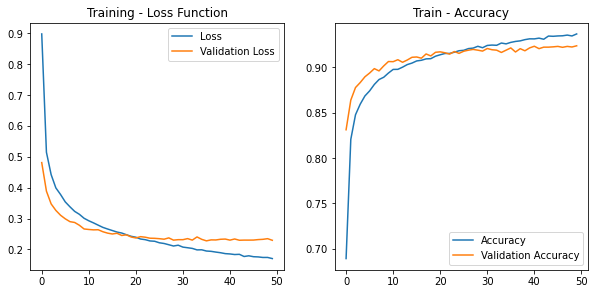

In [78]:
cnn_model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(10, activation='softmax')
])
print(cnn_model.summary())
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
cnn_model_history = cnn_model.fit(X_train_2d, y_train, batch_size=1024, epochs=50, verbose=1, validation_data=(X_val_2d, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(cnn_model_history.history['loss'], label='Loss')
plt.plot(cnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(cnn_model_history.history['acc'], label='Accuracy')
plt.plot(cnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

# y_pred = model.predict_classes(X_test)


plt.show()

In [79]:
test_loss, test_acc = cnn_model.evaluate(X_test_2d, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 1s 82us/step
Test Loss: 0.21633087732493878, Test accuracy: 0.9255


### <font color="purple">So, I decide to use 35 epoch for this final CNN model (1conv+1pool).<font>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        640       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_68 (Dense)             (None, 64)                802880    
_________________________________________________________________
dropout_36 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 10)                650       
Total para

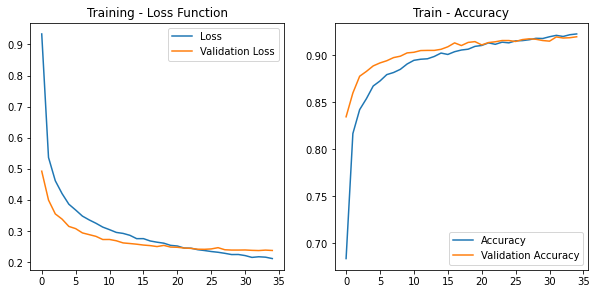

In [80]:
cnn_model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(10, activation='softmax')
])
print(cnn_model.summary())
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
cnn_model_history = cnn_model.fit(X_train_2d, y_train, batch_size=1024, epochs=35, verbose=1, validation_data=(X_val_2d, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(cnn_model_history.history['loss'], label='Loss')
plt.plot(cnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(cnn_model_history.history['acc'], label='Accuracy')
plt.plot(cnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

plt.show()

In [81]:
test_loss, test_acc = cnn_model.evaluate(X_test_2d, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 1s 82us/step
Test Loss: 0.22568674718737602, Test accuracy: 0.9202



CNN:
---------------------
Confusion Matrix: 


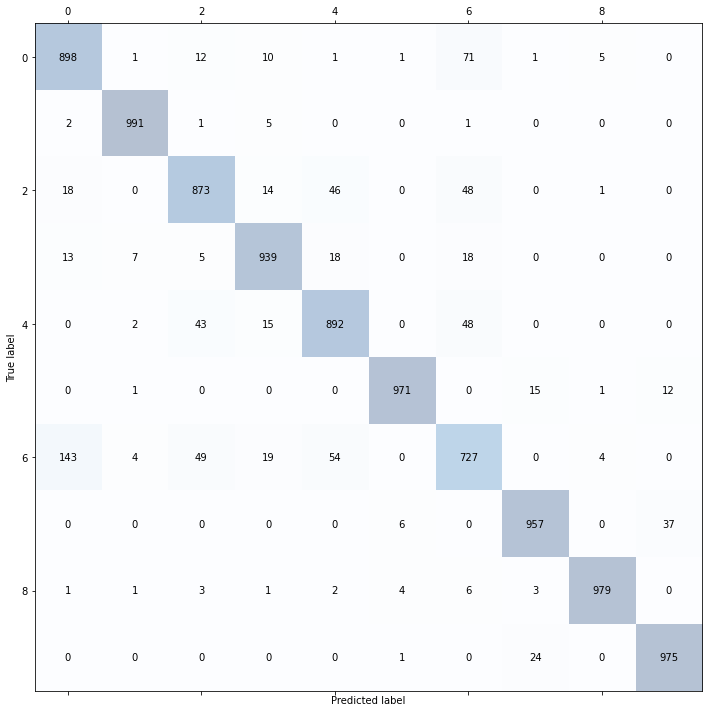

In [82]:
y_pred = cnn_model.predict_classes(X_test_2d)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
print('\nCNN:\n---------------------\nConfusion Matrix: ')
plt.show()

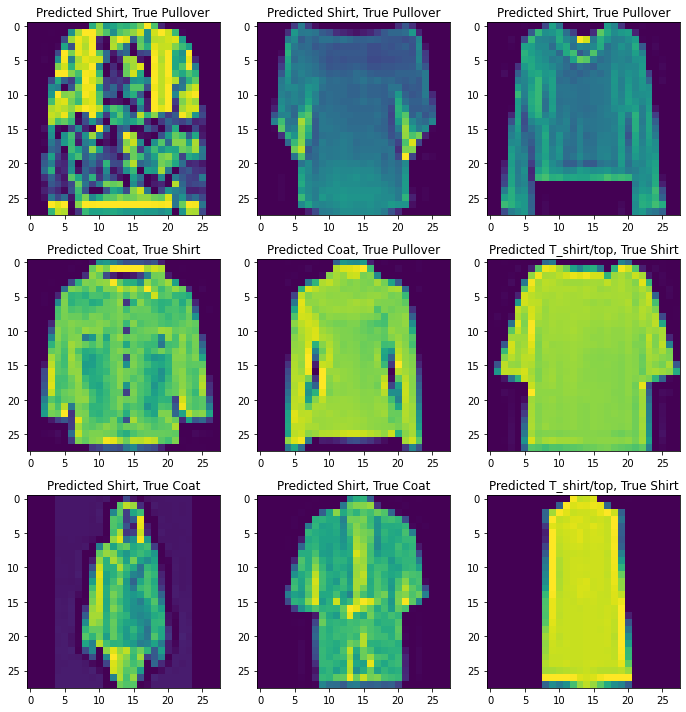

In [83]:
incorrect = np.nonzero(y_pred != y_test)[0]
plt.figure(figsize=(10, 10))
for i, incorrect_idx in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect_idx].reshape(28,28))
    plt.title("Predicted {}, True {}".format(class_label[y_pred[incorrect_idx]], class_label[y_test[incorrect_idx]]))
    plt.tight_layout()

### <font color="purple">Good!! Let's try add a conv+pool, may be better?<font>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        640       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 3136)              0         
__________

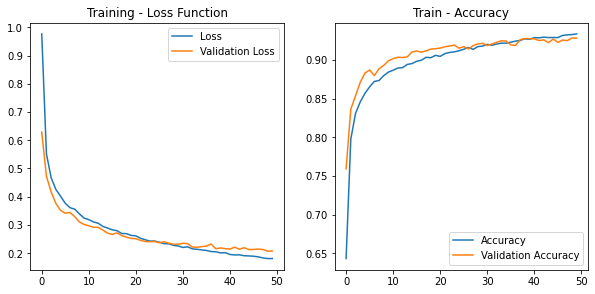

In [84]:
cnn_model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
])
print(cnn_model.summary())
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
cnn_model_history = cnn_model.fit(X_train_2d, y_train, batch_size=1024, epochs=50, verbose=1, validation_data=(X_val_2d, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(cnn_model_history.history['loss'], label='Loss')
plt.plot(cnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(cnn_model_history.history['acc'], label='Accuracy')
plt.plot(cnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

plt.show()

In [85]:
test_loss, test_acc = cnn_model.evaluate(X_test_2d, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 1s 89us/step
Test Loss: 0.19347733271121978, Test accuracy: 0.9309



CNN:
---------------------
Confusion Matrix: 


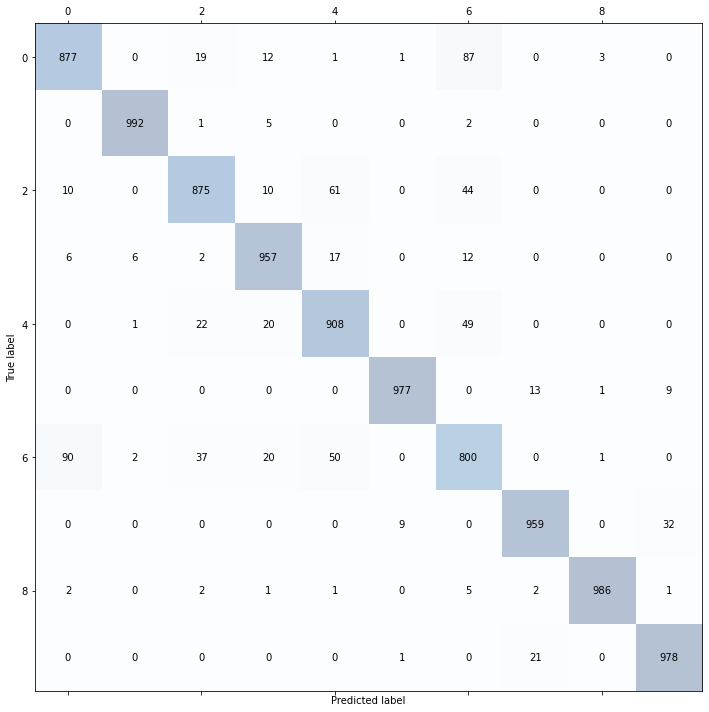

In [86]:
y_pred = cnn_model.predict_classes(X_test_2d)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
print('\nCNN:\n---------------------\nConfusion Matrix: ')
plt.show()

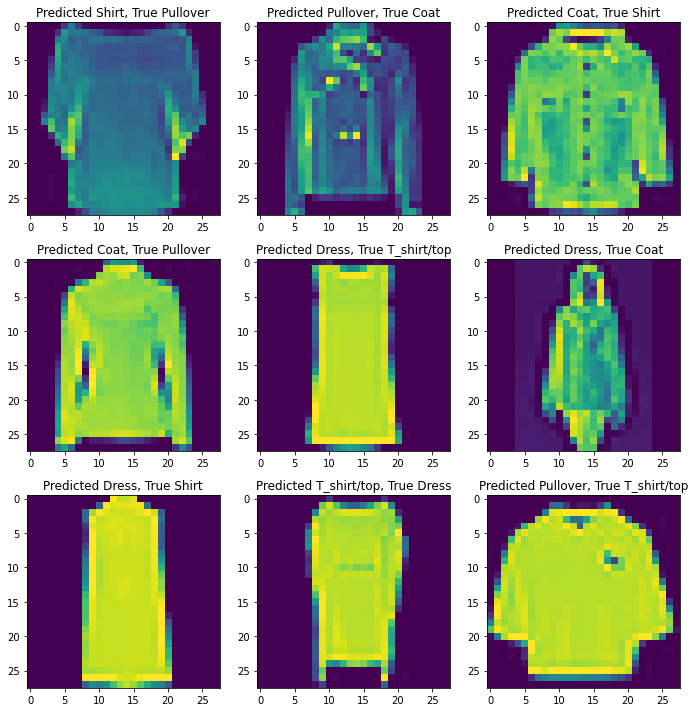

In [87]:
incorrect = np.nonzero(y_pred != y_test)[0]
plt.figure(figsize=(10, 10))
for i, incorrect_idx in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect_idx].reshape(28,28))
    plt.title("Predicted {}, True {}".format(class_label[y_pred[incorrect_idx]], class_label[y_test[incorrect_idx]]))
    plt.tight_layout()

### <font color="purple">Try some different layer (Batch Normalization layer)<font>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 28, 28, 64)        640       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 7, 7, 64)          0         
__________

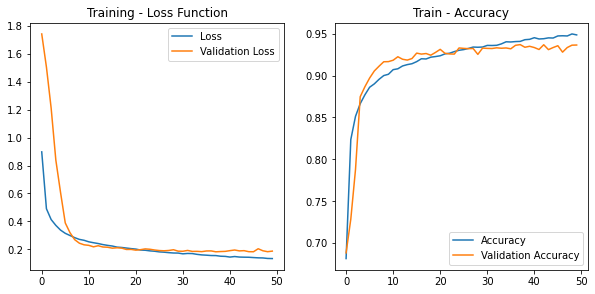

In [89]:
# add batch norm

cnn_model = tf.keras.Sequential([
            tf.keras.layers.BatchNormalization(input_shape=(28, 28, 1)),
            
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),
            tf.keras.layers.Dropout(0.4),
            
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'),
            tf.keras.layers.Dropout(0.4),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(10, activation='softmax')
])
print(cnn_model.summary())
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
cnn_model_history = cnn_model.fit(X_train_2d, y_train, batch_size=1024, epochs=50, verbose=1, validation_data=(X_val_2d, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(cnn_model_history.history['loss'], label='Loss')
plt.plot(cnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(cnn_model_history.history['acc'], label='Accuracy')
plt.plot(cnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')
plt.show()

In [90]:
test_loss, test_acc = cnn_model.evaluate(X_test_2d, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 1s 92us/step
Test Loss: 0.1725310632362962, Test accuracy: 0.9386



CNN(batch norm):
---------------------
Confusion Matrix: 


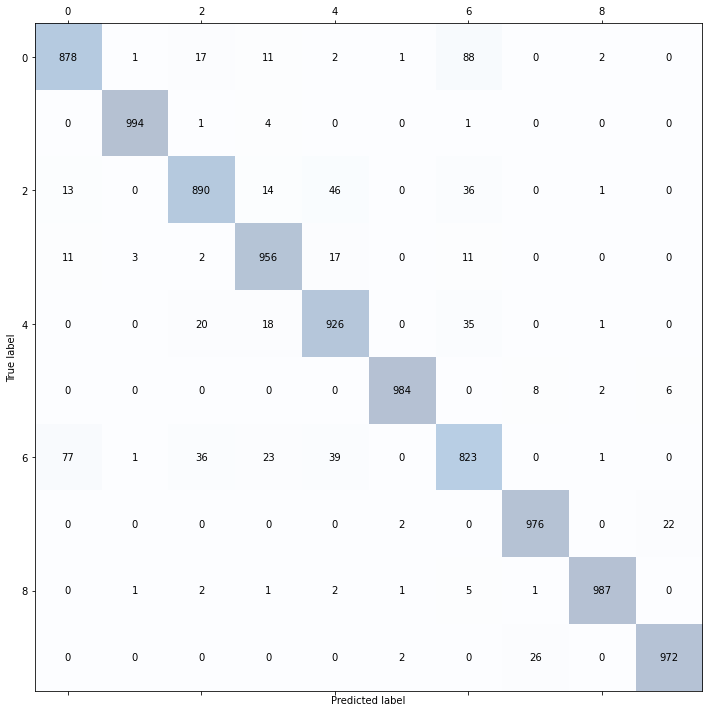

In [91]:
y_pred = cnn_model.predict_classes(X_test_2d)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
print('\nCNN(batch norm):\n---------------------\nConfusion Matrix: ')
plt.show()

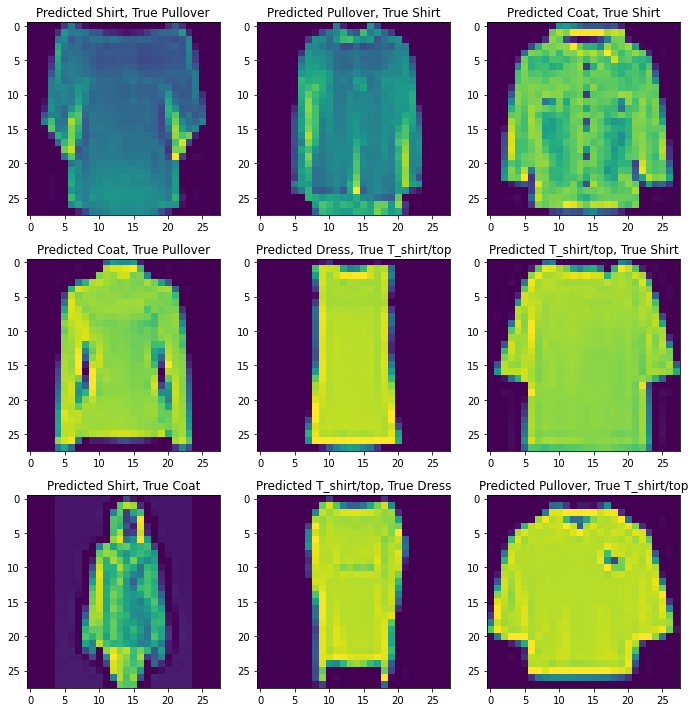

In [92]:
incorrect = np.nonzero(y_pred != y_test)[0]
plt.figure(figsize=(10, 10))
for i, incorrect_idx in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect_idx].reshape(28,28))
    plt.title("Predicted {}, True {}".format(class_label[y_pred[incorrect_idx]], class_label[y_test[incorrect_idx]]))
    plt.tight_layout()

### <font color="purple">That's great! Accuracy is about 93.86%!<font>

### <font color="purple">Try add more conv, FC layer and batch normalization layer!<font>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 64)        256       
__________

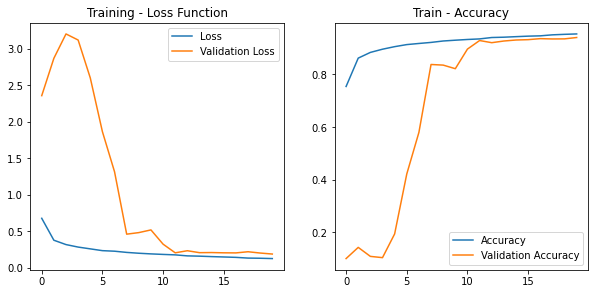

In [93]:
# Add more conv and FC layer and batch norm layer

cnn_model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
            tf.keras.layers.Dropout(0.3),
            
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
            tf.keras.layers.Dropout(0.4),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(10, activation='softmax')
])
print(cnn_model.summary())
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
cnn_model_history = cnn_model.fit(X_train_2d, y_train, batch_size=1024, epochs=20, verbose=1, validation_data=(X_val_2d, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(cnn_model_history.history['loss'], label='Loss')
plt.plot(cnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(cnn_model_history.history['acc'], label='Accuracy')
plt.plot(cnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

# y_pred = model.predict_classes(X_test)
test_loss, test_acc = cnn_model.evaluate(X_test_2d, y_test)
print(test_loss, test_acc)

plt.show()

In [94]:
test_loss, test_acc = cnn_model.evaluate(X_test_2d, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 1s 108us/step
Test Loss: 0.18285263526961207, Test accuracy: 0.9422



CNN(batch norm) more complex:
---------------------
Confusion Matrix: 


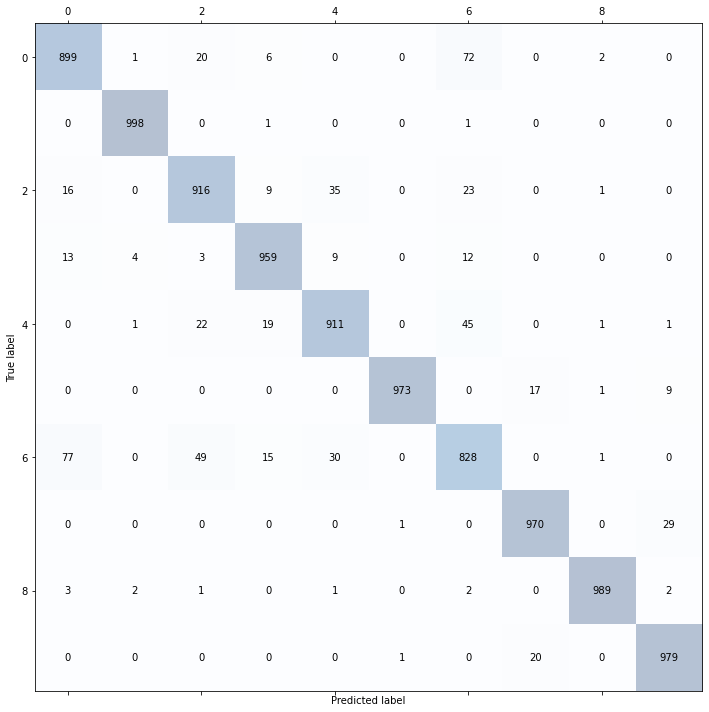

In [95]:
y_pred = cnn_model.predict_classes(X_test_2d)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
print('\nCNN(batch norm) more complex:\n---------------------\nConfusion Matrix: ')
plt.show()

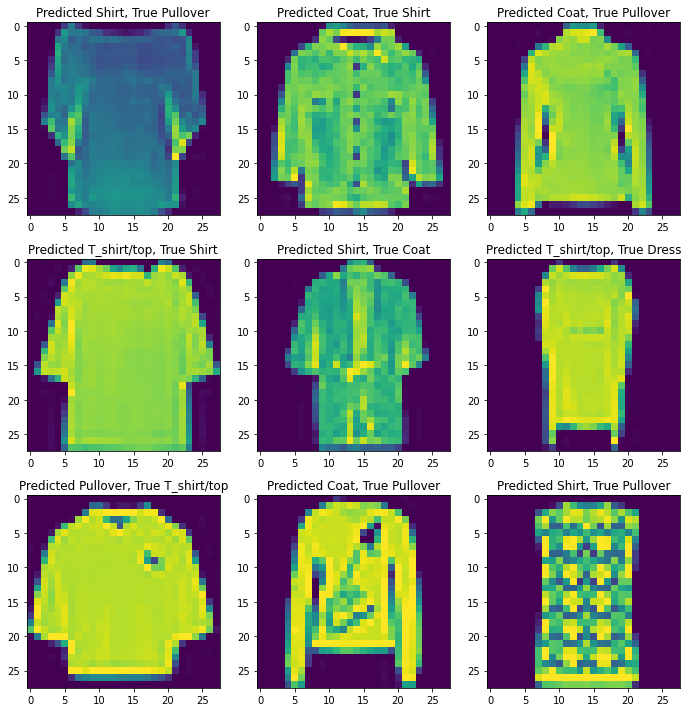

In [96]:
incorrect = np.nonzero(y_pred != y_test)[0]
plt.figure(figsize=(10, 10))
for i, incorrect_idx in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect_idx].reshape(28,28))
    plt.title("Predicted {}, True {}".format(class_label[y_pred[incorrect_idx]], class_label[y_test[incorrect_idx]]))
    plt.tight_layout()

### <font color="purple">Try a famous architecture (VGG style network)<font>


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 28, 28, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 7, 7, 256)         295168    
__________

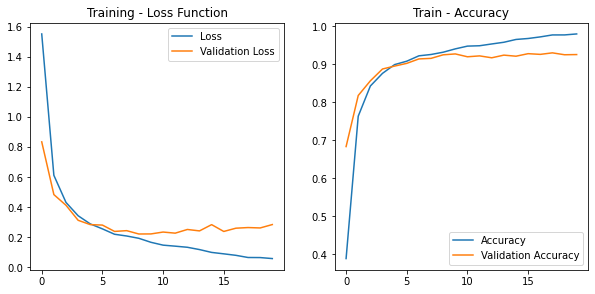

In [97]:
# VGG style

cnn_model = tf.keras.Sequential([              
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),

            tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'),

            tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'),
            tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'),
            tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'),

            tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'),
            tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'),
            tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(2048,activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(2048,activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10,activation='softmax')
])
print(cnn_model.summary())
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
cnn_model_history = cnn_model.fit(X_train_2d, y_train, batch_size=1024, epochs=20, verbose=1, validation_data=(X_val_2d, y_val))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(cnn_model_history.history['loss'], label='Loss')
plt.plot(cnn_model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(cnn_model_history.history['acc'], label='Accuracy')
plt.plot(cnn_model_history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

plt.show()

In [98]:
test_loss, test_acc = cnn_model.evaluate(X_test_2d, y_test)
print(f'Test Loss: {test_loss}, Test accuracy: {test_acc}')

10000/10000 [==============================] - 3s 256us/step
Test Loss: 0.278372757595405, Test accuracy: 0.9263



CNN(VGG Style):
---------------------
Confusion Matrix: 


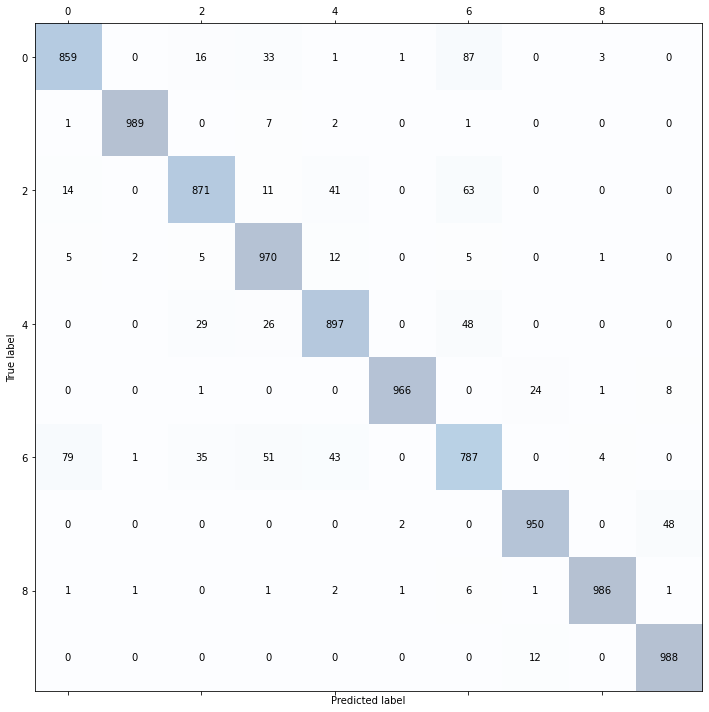

In [99]:
y_pred = cnn_model.predict_classes(X_test_2d)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
print('\nCNN(VGG Style):\n---------------------\nConfusion Matrix: ')
plt.show()

### Discussion & Conclusion

本次作業嘗試了各種不同的演算法去分類fashion mnist的dataset<br>
評估效能的方式主要是採用accuracy，除此之外去觀察confusion matrix的分布，來看model在哪種class的分類能力是相對不足的<br>
以下將以表格方式將前面所使用到的ML演算法、各種不同參數DNN、CNN的test accuracy進行整理，並討論、比較他們之間的區別<br>


Algorithms |  SVM(RBF kernel)  | Random forest | KNN  | 
--------------|:----------------------------:|:-----------------:|:-------------:|
Test Accuracy    |    0.8766          |0.8633 |  0.8553       | 

首先，上表是三種ML演算法的test accuracy，並且都是將data經過PCA轉換後去訓練出來的model，會這樣做的原因是此三類演算法在Scikit-learn上只能進行CPU運算，無法利用GPU加速<br>
可以發現到整體而言三者的表現都能大於85%，已經是不錯的水準<br>
而RBF kernel的表現是相對最好的，我認為是kernel轉換的特性讓他能以較高維度的觀點來進行分類，但缺點便是運算量相對其他兩者來的大，導致訓練時間較久<br>
Random forest其次，而KNN稍嫌差一點，但差距都不明顯，而KNN有一項優勢是他的計算方法相對簡單，因此訓練上比另外兩個演算法來的快<br>
儘管整體而言效果已經不錯，但我認為這種分類圖片的dataset使用neural network搭配GPU加速，應可達到更好的performance且訓練上更有效率<br>

Algorithms |  DNN(512 neurons) | DNN(256 neurons) | DNN(128 neurons)  | DNN(64 neurons)  | 
--------------|:----------------------------:|:-----------------:|:-------------:|:-------------:|
Test Accuracy    |    0.8954(overfit)          |0.892(overfit) |  0.8844       | 0.8753 |


上表是我設計one hidden layer的DNN，並去調整neuron unit的個數來去分類的結果，根據上表可以發現儘管只有一層DNN，但準確度已經接近或比ML傳統演算法來得優秀<br>
但設計DNN時需要非常小心的就是overfit的狀況，在我的調整下，512, 256個unit都會有較嚴重的overfitting情形(詳細的狀況已於前面訓練過程所描繪的loss curve所示)<br>
因此我認為64或128個unit是overfitting狀況較輕微，比較泛用的model，故我的設計是選定64 neurons來作為一個可用的基準點<br>
而稍微提一下此處的設定，activation function採用ReLU，optimizer則是採用Adam，這兩者會嘗試去更換來觀察結果<br>
至於loss的部分，我則是選定sparse ross-entropy，我認為已經足夠使用，故不會額外對loss進行深入的討論<br>

Algorithms |  DNN(64 neurons)+ReLU | DNN(64 neurons)+Sigmoid | DNN(64 neurons)+tanh  |
--------------|:----------------------------:|:-----------------:|:-------------:|
Test Accuracy    |    0.8753          |0.8652 |  0.8798       | 

接著，使用64 neurons的DNN來去更換看看不同的activation function<br>
上表是搭配三種不同的activation function，可以發現到ReLU的表現次之，而tanh似乎有最佳的表現<br>
但我認為，考慮到若把layer加深時tanh可能有gradient vanishing的問題，且運算起來ReLU是最優的，加上兩者的表現差距極小<br>
綜合以上考量，我決定選擇ReLU作為後面training使用的activation function<br>

Algorithms |  DNN(64 neurons)+Adam | DNN(64 neurons)+RMSprop | DNN(64 neurons)+Adagrad  |
--------------|:----------------------------:|:-----------------:|:-------------:|
Test Accuracy    |    0.8753         |0.868 |  0.8643       | 

根據上表討論一下optimizer，能發現到Adam的表現最好<br>
而考慮到Adam的泛用性最強，因此便決定使用Adam作為後面training使用的optimizer<br>

以下進入CNN的階段，將把我有嘗試的各種CNN models列出來做討論<br>

Algorithms |  CNN(1conv+1pool) | CNN(1conv+1pool)+1 dropout | CNN(1conv+1pool)+more dropout, 30 epochs |
--------------|:----------------------------:|:-----------------:|:-------------:|
Test Accuracy    |    0.9195(overfit)         |0.92 |  0.9192       | 


上表是嘗試1conv layer+1 pooling layer的CNN架構，以及加入dropout去處理overfit的結果<br>
可以發現到假如不使用dropout，則overfitting非常嚴重<br>
而加入dropout之後能大量改善overfitting情形，並且在30 epochs的時候overfit幾乎消失，test準確度達到0.9192，已經比前面方法都來得優秀，且overfit處理地很好！<br>

Algorithms | CNN(1conv+1pool)+more dropout, 30 epochs  | CNN(1conv+1pool)+more dropout, 50 epochs | CNN(1conv+1pool)+more dropout, 35 epochs |
--------------|:----------------------------:|:-----------------:|:-------------:|
Test Accuracy    |    0.9192         |0.9255 |  0.9202       | 

由於30 epochs時overfitting幾乎消失，讓我有動機去嘗試看看更多的epochs，因此上表就是嘗試更多epochs的結果<br>
當我固定dropout的強度，並把model的epochs數提升至50個時，儘管test accuracy提升了，但overfitting的現象又顯著不少，並不是所期望的狀況<br>
因此從loss curve來觀察，最終決定嘗試35 epochs應該是overfitting相對最不明顯，且test準確度最優的，達到了0.9202！

Algorithms |  CNN(2conv+2pool) | CNN(2conv+2pool+batch norm+one more FC) | CNN(Add more conv, FC, batch norm layers)  | CNN(VGG style)
--------------|:----------------------------:|:-----------------:|:-------------:|:-------------:|
Test Accuracy    |    0.9309         |0.9386 |  0.9422       | 0.9263 |

上表是增加更多的layer，並嘗試batch normalization layer以及VGG style network的結果<br>
首先能發現2conv+2pool的組合就能多提升約1%的準確度，達到了0.9309，且overfitting就如同一層的狀況一樣，並沒有更嚴重的現象，是十分理想的<br>
接著，根據2conv+2pool的組合嘗試看看加入batch norm layer和再加入FC layer，會發現準確度提升到了接近94%！(0.9386)<br>
但相對地，overfitting不再像2conv+2pool的時候那麼微弱，而是在訓練後期有較明顯的overfitting情況<br>
因此，根據前面的嘗試後，便去慢慢調整，加入、移除各式各樣的layer，來去觀察對model改善與否，最後就能得到上表第3種情況的model<br>
達到 **0.9422** 的test accuracy！而這也是我自己在train時所遇到表現最好且overfit也很微小的一個最優model<br>
我認為主因應歸功於batch norm layer的表現，不但幫助模型收斂，還能間接地能夠提升model performance<br>
最後，基於好奇心嘗試看看一些比較famous的network style，此處我選擇的是VGG net，仿造他的做法去construct一個model (維度上有經過些許調整)<br>
但由於是仿他的架構去實作，因此沒有特地去調整太多的參數，純粹是好奇把此network的架構拉來比較，最後出來的結果儘管不俗(0.9263)，但overfitting狀況明顯不少<br>
此原因我認為是network過於複雜，VGG style network採用了很多層conv+pooling的結構，而這次的dataset經由前面的訓練可以略知，如此大規模的model本身應該會有較為嚴重的overfitting<br>

上述演算法中，我會挑選幾個表現較佳的model，畫出其confusion matrix<br>
無論從哪個演算法去看，都能從confusion matrix中觀察到，6th class的分類對model來講是相對困難許多的，其他類別的分類錯誤情形都少很多，但只要與6th class有關係的分類，準確率就不是很理想<br>
為了更深入了解狀況，我在訓練model時會視情況把被錯誤分類的sample們，給plot出來會發現，許多T-shift, Pullover類的服裝和shirt被分類錯誤<br>
而我認為這部分若要改進，可能要嘗試用更厲害的方法去萃取更加詳細的feature，或是試試看data augmentation<br>
但事實上把錯誤sample畫出來後，其實連我自己都不是很能分得清楚差別，更別說model要學會辨識了，因此我認為這些sample的分類錯誤是有理由被接受的<br>

時間複雜度的部分，我認為ML傳統演算法的劣勢在於分類圖片的task通常利用CNN的方法是比較合適的，加上Scikit-learn並不支援GPU加速，使得靠純CPU的運算會吃不消。<br>
訓練上CNN花費的時間比DNN來得久，我認為是CNN本身卷積的運算就需要較多次的multiplication<br>
加上我所使用DNN layer都不深，neuron unit也不多所導致<br>
分析以上所有的model，三種主要方法內(ML, DNN, CNN)我認為CNN應該是最佳的<br>
而CNN中各項model的優劣，就取決於trade off怎麼考量，倘若選擇最準的model(i.e. 準確度達到0.9422的model)，那無可避免因為使用了更多層的conv layer使得訓練時間被拉長，但這項缺點經由batch norm的幫助下能夠改進，因為batch norm能夠幫助model收斂速度增快<br>
因此，我認為若考慮精準度，則這項0.9422精準度的model是最適合的<br>
但這個model用到的parameters也相對較多，約有3M多的大小，因此若考量到空間的實用性，以及需要更快的讓model train起來可用，則能考慮1conv+1pool的組合<br>
也就是稍微犧牲準確度(約2%)，來去換取更短的訓練時間(因為model複雜度低)<br>
而若要追求最立即的訓練時間，那我認為使用DNN的方法也並無不可，能夠在10幾秒的時間立刻達到接近90%的test accuracy，是追求時間的較適合方法<br>

總結，藉由這次作業，可以讓我們更加熟悉tensorflow套件的操作方式，並且了解如何使用DNN, CNN進行訓練<br>
CNN的部分更是上網查資料使用了一些以前有聽說，但沒有自己實作過的方法，算是學到更多CNN training的技巧了<br>
最後，花費大量時間training CNN，最後能得到還不錯的成效，成就感十足！<br>